In [3]:
#import libraries
import pandas as pd
import xgboost as xgb
import numpy as np

In [4]:
#importing dataset
dataset = pd.read_csv("bank-full.csv", sep = ";")
dataset.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [5]:
#isolate the x and y variables
y = dataset.iloc[:, -1].values
X = dataset._get_numeric_data()

In [6]:
#split dataset into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size =0.2,
                                                    random_state=1502)

In [7]:
#transform y factor variables
y_train = np.where(y_train == "yes", 1, 0)
y_test = np.where(y_test == "yes", 1, 0)
np.mean(y_train)
print("Mean of y_train: " + str(np.mean(y_train)))
print("Mean of y_test: " + str(np.mean(y_test)))

Mean of y_train: 0.11579296615792967
Mean of y_test: 0.12175163109587527


Sanity check to see if distribution of target value is the same in both `y_train` and `y_test`.  In this case, they are relatively close, around 12% of 100 people would indicate `yes (1)` to the product offering.

### DMatrix
Data Matrix is used in XGBoost.

`DMatrix` is an internal data structure that is used by XGBoost which is optimized for both memory efficiency and training speed.  You can construct DMatrix from numpy arrays.

In [8]:
#create xgboost matrices
Train = xgb.DMatrix(X_train, label = y_train)
Test = xgb.DMatrix(X_test, label = y_test)

In [9]:
#set the parameters
parameters1 = {'learning_rate': 0.3,
               'max_depth': 2,
               'colsample_bytree': 1,
               'subsample': 1,
               'min_child_weight': 1,
               'gamma': 0, 
               'random_state': 1502,
               'eval_metric': "auc",
               'objective': "binary:logistic"}

In [10]:
#run XGBoost
model1 = xgb.train(params = parameters1,
                   dtrain = Train,
                   num_boost_round = 200,
                   evals = [(Test, "Yes")],
                   verbose_eval = 50)

[0]	Yes-auc:0.73930
[50]	Yes-auc:0.87648
[100]	Yes-auc:0.87997
[150]	Yes-auc:0.88189
[199]	Yes-auc:0.88308


In [11]:
#PRedictions
predictions1 = model1.predict(Test)
predictions1 = np.where(predictions1 > 0.5, 1, 0)

In [12]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix1 = confusion_matrix(y_test, predictions1)
print(confusion_matrix1)
report1 = classification_report(y_test, predictions1)
print(report1)

[[7698  244]
 [ 746  355]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7942
           1       0.59      0.32      0.42      1101

    accuracy                           0.89      9043
   macro avg       0.75      0.65      0.68      9043
weighted avg       0.87      0.89      0.88      9043



### Transform categorical variables into dummy variables

In [13]:
#isolate the categorical variables
dataset_categorical = dataset.select_dtypes(exclude = "number")

#tranform categorical variables into dummy variables
dataset_categorical = pd.get_dummies(data = dataset_categorical,
                                     drop_first = True)

In [14]:
#joining numerical and categorical datasets
final_dataset = pd.concat([X, dataset_categorical], axis = 1)

In [15]:
#getting names of columns
feature_columns = list(final_dataset.columns.values)
feature_columns = feature_columns[:-1]

In [16]:
#isolate the x and y variables part 2
y = final_dataset.iloc[:, -1].values
X = final_dataset.iloc[:, :-1].values

In [17]:
#split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size =0.2,
                                                    random_state=1502)

In [18]:
#create xgboost matrices part 2
Train = xgb.DMatrix(X_train, label = y_train, feature_names = feature_columns)
Test = xgb.DMatrix(X_test, label = y_test, feature_names = feature_columns)

In [19]:
#set the parameters part 2
parameters2 = {'learning_rate': 0.3,
               'max_depth': 2,
               'colsample_bytree': 1,
               'subsample': 1,
               'min_child_weight': 1,
               'gamma': 0, 
               'random_state': 1502,
               'eval_metric': "auc",
               'objective': "binary:logistic"}

In [20]:
#run XGBoost
model2 = xgb.train(params = parameters2,
                   dtrain = Train,
                   num_boost_round = 200,
                   evals = [(Test, "Yes")],
                   verbose_eval = 50)

[0]	Yes-auc:0.73159
[50]	Yes-auc:0.91883
[100]	Yes-auc:0.92524
[150]	Yes-auc:0.92744
[199]	Yes-auc:0.92748


In [21]:
#Predictions part 2
predictions2 = model2.predict(Test)
predictions2 = np.where(predictions2 > 0.5, 1, 0)

In [22]:
#Confusion Matrix
confusion_matrix2 = confusion_matrix(y_test, predictions2)
print(confusion_matrix2)
report2 = classification_report(y_test, predictions2)
print(report2)

[[7662  280]
 [ 629  472]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7942
           1       0.63      0.43      0.51      1101

    accuracy                           0.90      9043
   macro avg       0.78      0.70      0.73      9043
weighted avg       0.89      0.90      0.89      9043



We see an improvement in the f1-score from 0.42 to 0.51 for class 1 after adding categorical features

In [23]:
#checking how many cores we have
import multiprocessing
multiprocessing.cpu_count()

8

In [24]:
#setting the cross validation parameters
from sklearn.model_selection import KFold
tune_control = KFold(n_splits = 5,
                     shuffle = True,
                     random_state = 1502).split(X = X_train,
                                                y = y_train)
                                                

In [25]:
#set parameter tuning
#set the parameters part 2
tune_grid = {'learning_rate': [0.05, 0.3], #search
               'max_depth': range(2, 9, 2), #search
               'colsample_bytree': [0.5, 1], #search
               'subsample': [1],
               'min_child_weight': [1],
               'gamma': [0], 
               'random_state': [1502],
               'n_estimators': range(200, 2000, 200), #search
               'booster': ["gbtree"]}    

In [26]:
#State that we are doing a classification problem
from xgboost import XGBClassifier
classifier = XGBClassifier(objective = "binary:logistic")

In [27]:
#Cross Validation Assembly
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = tune_grid,
                            scoring = "roc_auc",
                            n_jobs = 6,
                            cv = tune_control,
                            verbose = 5)

In [28]:
#Setting evaluation parameters
evaluation_parameters = {"early_stopping_rounds": 100,
                         "eval_metric": "auc",
                         "eval_set": [(X_test, y_test)]}

In [29]:
#Hyperparameter tuning and cross validation
#tune_model = grid_search.fit(X = X_train,
#                             y = y_train,
#                             **evaluation_parameters)
#grid_search.best_params_, grid_search.best_score_

Theory behind hyperparameters:\
YouTube Link: https://www.youtube.com/watch?v=AvWfL1Us3Kg

Uncomment cell above to rerun pass1 (2 hours to run)

Results from tuning pass 1:

<b>best params</b>:\
{'booster': 'gbtree',\
'colsample_bytree': 0.5,\
'gamma': 0,\
'learning_rate': 0.05,\
'max_depth': 8,\
'min_child_weight': 1,\
'n_estimators': 400,\
'random_state': 1502,\
'subsample': 1},

<b>best score</b>:\
0.9355509

In [30]:
#setting the cross validation parameters
from sklearn.model_selection import KFold
tune_control = KFold(n_splits = 5,
                     shuffle = True,
                     random_state = 1502).split(X = X_train,
                                                y = y_train)

In [33]:
#set parameter tuning
#set the parameters part 3
tune_grid2 = {'learning_rate': [0.05], 
               'max_depth': [8],
               'colsample_bytree': [0.5], 
               'subsample': [0.9, 1], #search
               'min_child_weight': range(1,5,1), #search
               'gamma': [0, 0.1], #search
               'random_state': [1502],
               'n_estimators': range(200, 2000, 200), #search
               'booster': ["gbtree"]}    

In [34]:
#Cross Validation Assembly
from sklearn.model_selection import GridSearchCV
grid_search2 = GridSearchCV(estimator = classifier,
                           param_grid = tune_grid2,
                            scoring = "roc_auc",
                            n_jobs = 6,
                            cv = tune_control,
                            verbose = 5)

In [36]:
#Hyperparameter tuning and cross validation
#tune_model2 = grid_search2.fit(X = X_train,
#                             y = y_train,
#                             **evaluation_parameters)
#grid_search2.best_params_, grid_search2.best_score_


Results from tuning pass 2:

<b>best params</b>:\
{'booster': 'gbtree',\
'colsample_bytree': 0.5,\
'gamma': 0.1,\
'learning_rate': 0.05,\
'max_depth': 8,\
'min_child_weight': 1,\
'n_estimators': 200,\
'random_state': 1502,\
'subsample': 1},

<b>best score</b>:\
0.9356276

In [37]:
#set the parameters part 3
parameters3 = {'learning_rate': 0.05,
               'max_depth': 8,
               'colsample_bytree': 0.5,
               'subsample': 1,
               'min_child_weight': 1,
               'gamma': 0.1, 
               'random_state': 1502,
               'eval_metric': "auc",
               'objective': "binary:logistic"}

In [38]:
#run XGBoost part 3
model3 = xgb.train(params = parameters3,
                   dtrain = Train,
                   num_boost_round = 800,
                   evals = [(Test, "Yes")],
                   verbose_eval = 50)

[0]	Yes-auc:0.85996
[50]	Yes-auc:0.92239
[100]	Yes-auc:0.92957
[150]	Yes-auc:0.93159
[200]	Yes-auc:0.93245
[250]	Yes-auc:0.93240
[300]	Yes-auc:0.93222
[350]	Yes-auc:0.93235
[400]	Yes-auc:0.93240
[450]	Yes-auc:0.93232
[500]	Yes-auc:0.93198
[550]	Yes-auc:0.93201
[600]	Yes-auc:0.93193
[650]	Yes-auc:0.93205
[700]	Yes-auc:0.93204
[750]	Yes-auc:0.93187
[799]	Yes-auc:0.93165


In [44]:
#Predictions part 3
predictions3 = model3.predict(Test)
predictions3 = np.where(predictions3 > 0.50, 1, 0)

In [45]:
#Confusion Matrix
confusion_matrix3 = confusion_matrix(y_test, predictions3)
print(confusion_matrix3)
report3 = classification_report(y_test, predictions3)
print(report3)

[[7641  301]
 [ 581  520]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7942
           1       0.63      0.47      0.54      1101

    accuracy                           0.90      9043
   macro avg       0.78      0.72      0.74      9043
weighted avg       0.89      0.90      0.90      9043



With a threshold of 0.50, we are yielding a recall of 0.47 (520 out of 1101).  This means that we are missing out on 581 cases where we predicted No, but in actuality it was a Yes.  So if we lower the threshold, we can avoid missing out on these potential customers.  We are already doing pretty well on precision/recall for the class 0, so it wouldn't hurt the business to call a few more leads.

In [48]:
#Predictions part 3
predictions3 = model3.predict(Test)
predictions3 = np.where(predictions3 > 0.05, 1, 0) #lower threshold from 0.5 to 0.05

In [49]:
#Confusion Matrix
confusion_matrix3 = confusion_matrix(y_test, predictions3)
print(confusion_matrix3)
report3 = classification_report(y_test, predictions3)
print(report3)

[[6299 1643]
 [  63 1038]]
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      7942
           1       0.39      0.94      0.55      1101

    accuracy                           0.81      9043
   macro avg       0.69      0.87      0.71      9043
weighted avg       0.92      0.81      0.84      9043



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

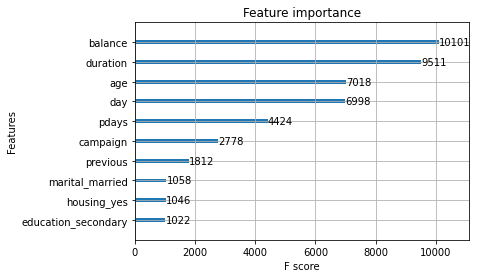

In [41]:
#plot importances
xgb.plot_importance(model3, max_num_features = 10)

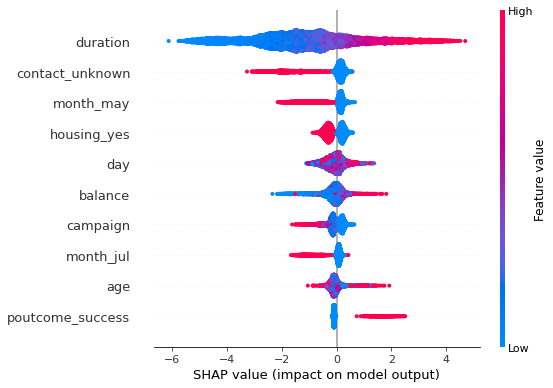

In [43]:
#Preparing SHAP
#pip install shap
#conda install -c conda-forge shap
import shap
explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(X_test)

#shap plotting
shap.summary_plot(shap_values,
                  X_test,
                  feature_names = feature_columns,
                  max_display = 10)